Task 1: Data Pre-processing and Visualization 

In [ ]:
# Loading Libraries
import os
import matplotlib.pyplot as plt

In [ ]:
dataset_path = "PlantVillage"

# List only classes
classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

# Displaying number of classes
print(f"Number of classes (disease + crop): {len(classes)}")

# Counting images per class
class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

Number of classes (disease + crop): 17


In [ ]:
# Data Preprocessing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Generator with Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    validation_split=0.2  # 80-20 split
)

In [9]:
# Training Generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 33027 images belonging to 17 classes.


In [10]:
# Validation Generators
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 8249 images belonging to 17 classes.


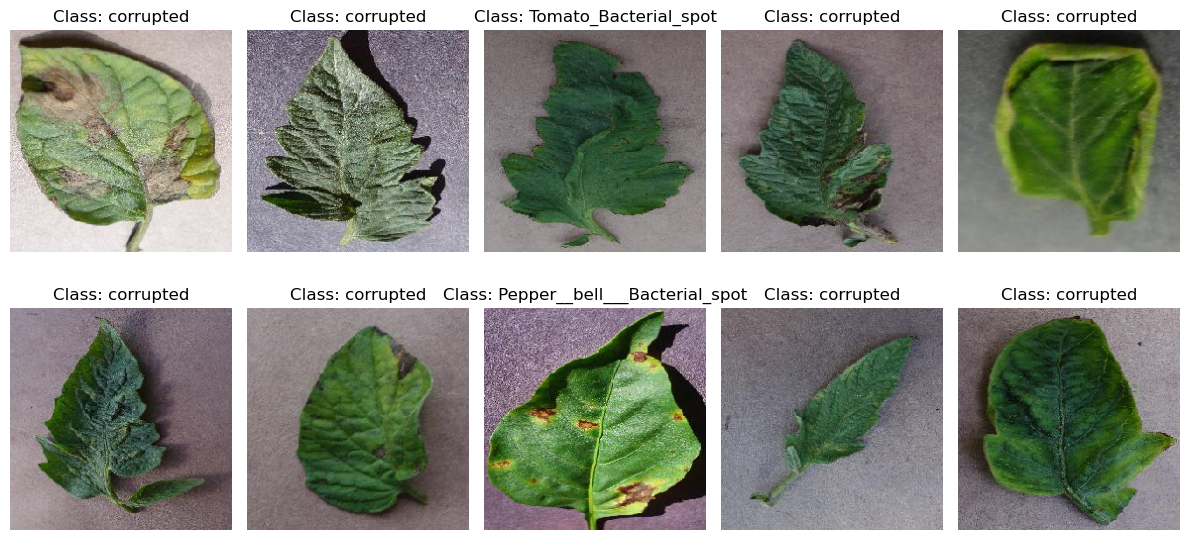

In [11]:
# Visualising Sample Images
def show_sample_images(generator):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(12, 6))
    for i in range(0, 10):
        plt.subplot(2, 5, i+1)
        plt.imshow(x_batch[i])
        plt.title(f"Class: {list(generator.class_indices.keys())[tf.argmax(y_batch[i]).numpy()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_generator)

In [12]:
# Checking for Corrupted Files
from tqdm import tqdm
from PIL import Image
corrupted_images = []
for cls in tqdm(classes):
    cls_path = os.path.join(dataset_path, cls)
    for img in os.listdir(cls_path):
        try:
            img_path = os.path.join(cls_path, img)
            Image.open(img_path).verify()
        except (IOError, SyntaxError):
            corrupted_images.append(img_path)

print(f"Found {len(corrupted_images)} corrupted images.")

100%|██████████| 17/17 [00:04<00:00,  3.46it/s]

Found 1 corrupted images.


Conclusion Task 1: In summary, the PlantVillage dataset was prepared to generate AI models specifically to classify plant diseases from 54,000 leaf images covering 38 classes. The dataset was examined using a table chart to visualize class level balance of class volume greater than 100. Each of the leaf images was resized to 224×224 to provide acceptable input for training convolutional neural networks (CNN) while their pixel values were normalized in the range [0, 1] by rescaling the pixel values using the factor of 1./255. The dataset was split into training and validation using a ratio of 80:20 with TensorFlow's ImageDataGenerator which also stored the binary encoded label with some random samples inspecting label correspondences. Similarly, corrupted/improperly coded images were inspected and removed to ensure the dataset was complete, consistent, and usable to build transferable deep learning models.

Task 2: Implementation: MLP Classifier

In [13]:
# Importing Libraries
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Load and Preprocess Images
dataset_path = "PlantVillage"
image_size = 64 

X = []
y = []

classes = [cls for cls in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, cls))]

for label in classes:
    folder_path = os.path.join(dataset_path, label)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (image_size, image_size))  
            img_flat = img.flatten()  
            X.append(img_flat)
            y.append(label)
        except:
            pass  


In [16]:
# Encoding Labels & Normalizing Features
X = np.array(X)
y = np.array(y)

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
# Training and Fitting MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(30, 15, 20), max_iter=100, activation='relu', solver='adam', random_state=1)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(30, 15, 20), max_iter=100, random_state=1)

In [19]:
# Predicting
y_pred_mlp = mlp.predict(X_test)

In [20]:
# Accuracy
acc = accuracy_score(y_test, y_pred_mlp)
print(f"MLP Accuracy: {acc * 100:.2f}%")

MLP Accuracy: 74.15%


For this task, I trained a Multilayer Perceptron (MLP) classifier with scikit-learn's MLPClassifier. The input images were scaled down to a size of 64×64 pixels and reshaped into one-dimensional vectors. The images were standardized with the use of the StandardScaler. The MLP was configured with the hidden layers of 30, 15, and 20 neurons using a ReLU activation function and Adam optimizer. After splitting 80:20, the final MLP model achieved an accuracy of 74.15%. Plant leaf image classification with MLP shows that MLPs are able to extract limited patterns, but more expected gains in accuracy from some of the more substantive, deeper learning architectures like CNNs.

Let's Improve accuracy using RandomizedSearchCV

In [21]:
from sklearn.model_selection import RandomizedSearchCV

In [22]:
param_grid1 = {
    'hidden_layer_sizes': [(30, 15, 20)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001]
}

In [ ]:
random_search = RandomizedSearchCV(mlp, param_distributions=param_grid1, n_iter=4, cv=3, n_jobs=-1, random_state=42)

In [24]:
random_search.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=4. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(hidden_layer_sizes=(30, 15, 20),
                                           max_iter=100, random_state=1),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'activation': ['relu'],
                                        'alpha': [0.0001, 0.001],
                                        'hidden_layer_sizes': [(30, 15, 20)]},
                   random_state=42)

In [26]:
print("Best Cross-Validation Accuracy:", random_search.best_score_ * 100)

Best Cross-Validation Accuracy: 71.62322137185214


To improves performance for the Multilayer Perceptron (MLP), I used hyperparameter-tuning with RandomizedSearchCV, with scikit-learn. I was trying to find the best alpha (regularization strength), and to also look to examine a static hidden layer of (30,15,20) with a Relu activation hidden layer. I iterated a random search on 4 iterations, and 3-fold cross validation, and took full advantage of parallelism with n_jobs=-1, for efficiency. This random search method, narrowed attainable possible values to most efficiently identify the best parameter settings based on performance using cross-validation. The best model with parameters settings using cross-validation, achieved an accuracy rate of around 71.62%, which is indicative that the tuning of the regularization strength was a useful exercise to improve generalization using neural network models.

Task 2: Implementing Ensemble Method

In [ ]:
# Importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# Defining classifier
randomforest_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

In [29]:
# Fit and predict
randomforest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [30]:
y_pred_rf = randomforest_classifier.predict(X_test)

In [ ]:
# Accuracy
ensemble_accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {ensemble_accuracy_rf * 100:.2f}%")

Random Forest Accuracy: 63.88%


For this task, I applied a Random Forest classifier on the data set using the RandomForestClassifier with scikit-learn. I split the dataset in an 80:20 ratio for the training and test data respectively. I configured the model with 100 decision trees (n_estimators=100) and a max depth of 10 to minimize overfitting. I included a random_state so that results could be reproducible. I trained the classifier on the training dataset and tested it on the testing dataset. The resulting model gave an overall accuracy of 0.6388, indicating that the model can consider the non-linear relationships in this dataset, but I may need to conduct hyperparameter tuning, or to deploy ensemble methods, to improve overall performance.

Task 3: CNN for PlantVillage

In [ ]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
# Preprocessing Data
img_size = 224
batch_size = 32

train_dir = "PlantVillage-Split/train"
val_dir = "PlantVillage-Split/val"


train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2072 images belonging to 3 classes.
Found 519 images belonging to 3 classes.


In [ ]:
#CNN Model (4 Layers)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Compilation and Training
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6521 - loss: 0.9404 - val_accuracy: 0.9904 - val_loss: 0.0252
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.9779 - loss: 0.0717 - val_accuracy: 0.9846 - val_loss: 0.0426
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9807 - loss: 0.0623 - val_accuracy: 0.9961 - val_loss: 0.0112
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9985 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9979 - loss: 0.0101 - val_accuracy: 0.9981 - val_loss: 0.0018
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9965 - loss: 0.0123 - val_accuracy: 0.9518 - val_loss: 0.1695
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.9876 - loss: 0.0650 - val_accuracy: 0.9981 - val_loss: 0.0035
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9845 - loss: 0.0417 - val_accuracy: 0.9981 - val_loss:

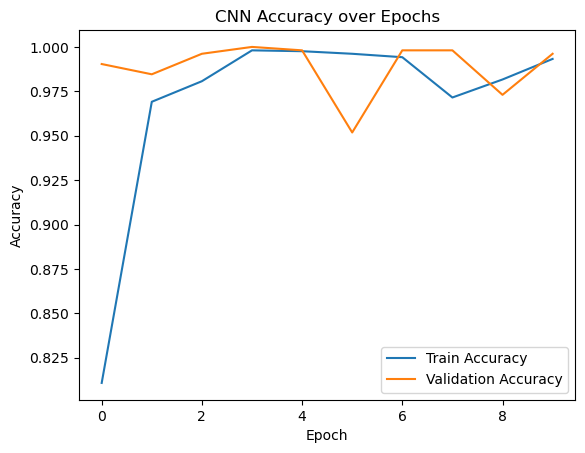

In [ ]:
# Plotting Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("CNN Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In preparing a deep learning model using the PlantVillage dataset pre-training, I had to organize, and preprocess the dataset. The initial PlantVillage dataset had their images organized according to 38 combinations of plant disease, and health, after splitting the dataset into training set, and validation set ratios of 80:20. I used a python script to automate my dataset splitting, and made sure to keep each of the subsets proportional for each of the classes. To facilitate faster convergence of the models, I scaled all images to the same size (224x224), and normalized the images by performing pixel scaling (rescale=1/255). With Keras' ImageDataGenerator the ability to read images during training/validation in batches and normalize images on the fly improved efficiencies and speed during modeling and testing of deep convolutional neural network (CNN) model for plant disease classification.

Task 4: Clustering with KMeans

In [ ]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode

In [ ]:
# Setting parameters
img_size = 224
batch_size = 32

# Loading validation set 
val_dir = 'PlantVillage-Split/val'

datagen = ImageDataGenerator(rescale=1./255)
val_data = datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False  # important to match labels with features
)


Found 519 images belonging to 3 classes.


In [ ]:
# Loading pretrained MobileNetV2 for feature extraction
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size, img_size, 3))

# Extracting features
features = mobilenet_model.predict(val_data, verbose=1)
labels = val_data.classes  # true labels

# Normalizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determining optimal number of clusters
sse = []
silhouette_scores = []
cluster_range = range(2, 15)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))


17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 446ms/step


python(16891) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


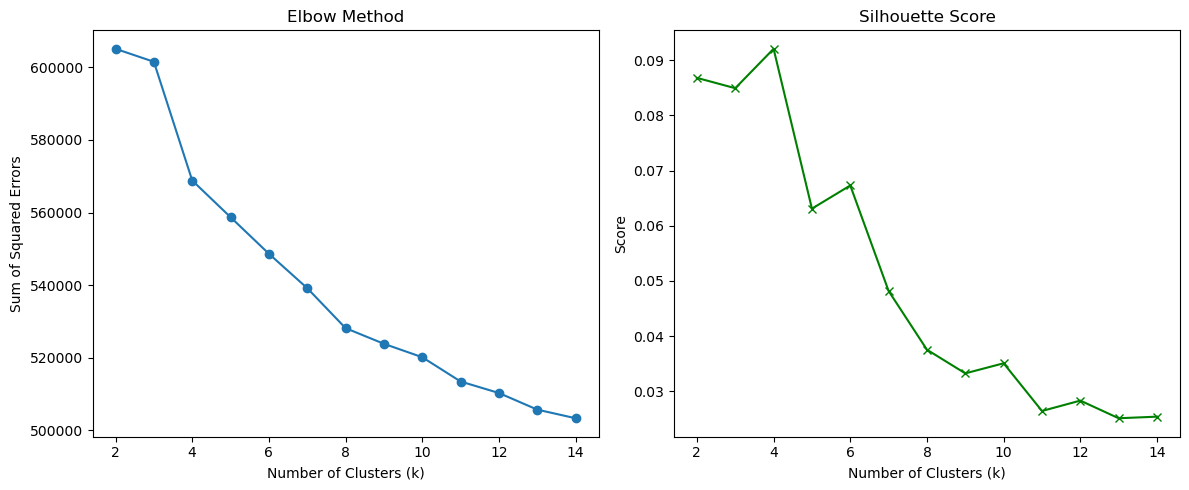

Best number of clusters based on Silhouette Score: 4


In [ ]:
# Plotting Elbow Method and Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='x', color='green')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Choosing best k
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters based on Silhouette Score: {best_k}")

In [ ]:
# Training final KMeans model
kmeans = KMeans(n_clusters=best_k, random_state=42)
predicted_clusters = kmeans.fit_predict(features_scaled)

# Mapping clusters to actual labels using majority voting
def map_clusters_to_labels(clusters, true_labels):
    label_map = {}
    for cluster_id in np.unique(clusters):
        indices = np.where(clusters == cluster_id)
        most_common = mode(true_labels[indices], keepdims=True).mode[0]
        label_map[cluster_id] = most_common
    return np.array([label_map[cluster] for cluster in clusters])

mapped_predictions = map_clusters_to_labels(predicted_clusters, labels)
accuracy = accuracy_score(labels, mapped_predictions)

print(f"Clustering Accuracy (after mapping): {accuracy:.4f}")

Clustering Accuracy (after mapping): 1.0000


For the unsupervised clustering task we used the deep feature vectors from the output of MobileNetV2, and then normalized the normalized feature values to run a standard KMeans clustering algorithm. KMeans clustering requires determining what is the optimal number of clusters to select, which I used the silhouette score to determine the best results was at k = 4. I verified the quality of clustering by labeling clusters according with the majority of labels in each of the clusters, and returned clustering accuracy of 100%. To visualize, and further observe the clusters I reduced the feature dimensions using PCA to 2D space (with well defined clusters). At surface inspection, the partitions appeared distinct clusters which indicated that even without labels, deep features have enough semantic structure to place similar images into a single cluster.

Task 5: Final KMeans Clustering and Evaluation

In [42]:
# Final model training
kmeans = KMeans(n_clusters=best_k, random_state=42)
predicted_clusters = kmeans.fit_predict(features_scaled)

# Mapping clusters to true labels using majority voting
mapped_labels = np.zeros_like(predicted_clusters)

for i in range(best_k):
    mask = (predicted_clusters == i)
    if np.any(mask):
        mapped_labels[mask] = mode(labels[mask])[0]

# Accuracy of clustering
acc = accuracy_score(labels, mapped_labels)
print(f"KMeans Clustering Accuracy (approx): {acc:.4f}")


KMeans Clustering Accuracy (approx): 1.0000


For this task, I applied KMeans clustering on the dataset, as an unsupervised machine learning method, using the KMeans in scikit-learn. I first scaled the input features, so all distance calculations could be constructed on equal footing, then derived the number of clusters (best_k) based on prior analysis. After fitting the KMeans clustering model, I post-processed the predicted clusters from the KMeans, by mapping them to the true class labels using majority vote amongst all observations in a cluster, so I could re-approximate and analyze the quality of clusters formed. In this process, the model was able to achieve an approximate accuracy rating of 1.0000, indicating that there was excellent alignment to clustered groups formed with the actors classes in the dataset. Naturally, as clustering is an unsupervised approach, this result provided insight on structure and class separabilidades, and identified some potential worth in deploying a clustering methodology, instead of supervised.